In [1]:
import os
import random
import soundfile as sf
import torch
import yaml
import json
import argparse
import pandas as pd
from tqdm import tqdm
from pprint import pprint
from pathlib import Path

from asteroid.metrics import get_metrics
from asteroid.utils import tensors_to_device
from asteroid.dsp.normalization import normalize_estimates

import matplotlib.pyplot as plt 
import numpy as np

import sys 
sys.path.append("/data1/wangyiwen/repos/graduateproject/speakerbeam/src/")

from models.td_speakerbeam import TimeDomainSpeakerBeam as Model1
from models.td_speakerbeam_sep2vec import TimeDomainSpeakerBeamPredictHelp as Model2

In [19]:
# load model1 
model1 = Model1(i_adapt_layer=7, adapt_layer_type='mul', adapt_enroll_dim=128, causal=True)
model1_path = "/data1/wangyiwen/repos/graduateproject/speakerbeam/egs/libri2mix/exp/20240629_mixloss/checkpoints/epoch=198-step=115221.ckpt"
ckpt = torch.load(model1_path, map_location = torch.device('cpu')) 
state_dict = {} 
for k in ckpt['state_dict']: 
    state_dict[k.split('.',1)[1]] = ckpt['state_dict'][k]
model1.load_state_dict(state_dict)
# print(model1.decoder.get_filters())
print(model1)

TimeDomainSpeakerBeam(
  (encoder): Encoder(
    (filterbank): FreeFB()
  )
  (masker): TDConvNetInformed(
    (bottleneck): Sequential(
      (0): CumLN()
      (1): Conv1d(512, 128, kernel_size=(1,), stride=(1,))
    )
    (TCN): ModuleList(
      (0): Conv1DBlock(
        (shared_block): Sequential(
          (0): Conv1d(128, 512, kernel_size=(1,), stride=(1,))
          (1): PReLU(num_parameters=1)
          (2): CumLN()
          (3): Sequential(
            (0): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(2,), groups=512)
            (1): _Chop1d()
          )
          (4): PReLU(num_parameters=1)
          (5): CumLN()
        )
        (res_conv): Conv1d(512, 128, kernel_size=(1,), stride=(1,))
        (skip_conv): Conv1d(512, 128, kernel_size=(1,), stride=(1,))
      )
      (1): Conv1DBlock(
        (shared_block): Sequential(
          (0): Conv1d(128, 512, kernel_size=(1,), stride=(1,))
          (1): PReLU(num_parameters=1)
          (2): CumLN()
          (3

In [18]:
# load model1 
model2 = Model2(i_adapt_layer=7, adapt_layer_type='mul', adapt_enroll_dim=128, kernel_size=16, causal=True)
model2_path = "/data1/wangyiwen/repos/graduateproject/speakerbeam/egs/libri2mix_sep2vec/exp/20240630_mixloss_autoregression_fixed_pretrained_16sample_50epochcircle/checkpoints/epoch=18-step=8246.ckpt"
ckpt = torch.load(model2_path, map_location = torch.device('cpu')) 
state_dict = {} 
for k in ckpt['state_dict']: 
    state_dict[k.split('.',1)[1]] = ckpt['state_dict'][k]
model2.load_state_dict(state_dict)
print(model2.decoder.get_filters())

Parameter containing:
tensor([[[-0.0098,  0.0132,  0.0176,  ...,  0.0130,  0.0159, -0.0055]],

        [[-0.0016, -0.0013,  0.0096,  ...,  0.0049,  0.0041,  0.0051]],

        [[-0.0012,  0.0028,  0.0078,  ..., -0.0024, -0.0054, -0.0076]],

        ...,

        [[ 0.0101,  0.0150,  0.0176,  ..., -0.0165, -0.0151, -0.0133]],

        [[-0.0083, -0.0083, -0.0013,  ...,  0.0084,  0.0222,  0.0263]],

        [[-0.0319, -0.0181,  0.0071,  ..., -0.0164, -0.0224, -0.0154]]],
       requires_grad=True)


In [7]:
model = Model(i_adapt_layer=7, adapt_layer_type='mul', adapt_enroll_dim=128, causal=True)
model_path = "/data1/wangyiwen/repos/graduateproject/speakerbeam/egs/libri2mix_sep2vec/exp/auto_regression_0_3_16sample_cgLN/checkpoints/epoch=49-step=28950.ckpt"
ckpt = torch.load(model_path, map_location = torch.device('cpu')) 
state_dict = {} 
for k in ckpt['state_dict']: 
    state_dict[k.split('.',1)[1]] = ckpt['state_dict'][k]
model.load_state_dict(state_dict)

<All keys matched successfully>

In [3]:
test_input = 0.1*torch.randn(1, 5000)
test_enroll_input = 0.1*torch.randn(1, 32000)
test_predict_delay = torch.zeros(test_input.shape)
test_predict_delay[0, 16:] = test_input[0, :-16]
# test_input = test_input.cuda()
# test_enroll_input = test_enroll_input.cuda()
# test_predict_delay = test_predict_delay.cuda()
# model = model.cuda()
model.eval()


TimeDomainSpeakerBeamPredictHelp(
  (encoder): Encoder(
    (filterbank): FreeFB()
  )
  (masker): TDConvNetInformedSeparateHelp(
    (bottleneck): Sequential(
      (0): CumLN()
      (1): Conv1d(512, 128, kernel_size=(1,), stride=(1,))
    )
    (TCN): ModuleList(
      (0): Conv1DBlock(
        (shared_block): Sequential(
          (0): Conv1d(128, 512, kernel_size=(1,), stride=(1,))
          (1): PReLU(num_parameters=1)
          (2): CumLN()
          (3): Sequential(
            (0): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(2,), groups=512)
            (1): _Chop1d()
          )
          (4): PReLU(num_parameters=1)
          (5): CumLN()
        )
        (res_conv): Conv1d(512, 128, kernel_size=(1,), stride=(1,))
        (skip_conv): Conv1d(512, 128, kernel_size=(1,), stride=(1,))
      )
      (1): Conv1DBlock(
        (shared_block): Sequential(
          (0): Conv1d(128, 512, kernel_size=(1,), stride=(1,))
          (1): PReLU(num_parameters=1)
          (2

(30160,) (36240,)


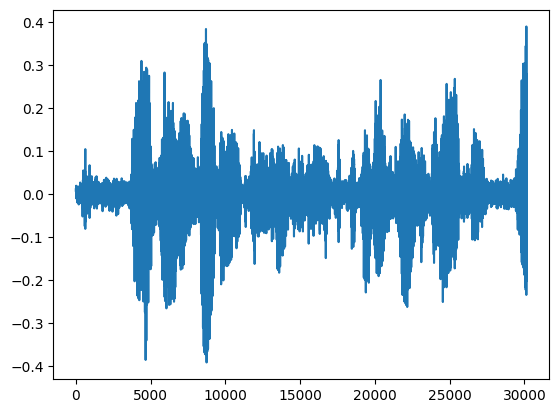

In [4]:
import soundfile as sf 
import numpy as np 
mixture_wavpath = "/data1/wangyiwen/repos/graduateproject/speakerbeam/egs/libri2mix_sep2vec/exp/auto_regression_0_3_16sample_cgLN/out_mix_src_enroll/4077-13754-0001_5142-33396-0065_MIX_0.wav"
source,_ = sf.read(mixture_wavpath, dtype="float32",)
source1_wavpath = "/data1/wangyiwen/repos/graduateproject/speakerbeam/egs/libri2mix_sep2vec/exp/auto_regression_0_3_16sample_cgLN/out_mix_src_enroll/4077-13754-0001_5142-33396-0065_ENR_0.wav"
enroll, _ = sf.read(source1_wavpath, dtype="float32",)
print(source.shape, enroll.shape)
plt.plot(source)
test_input = torch.from_numpy(source).reshape(1, -1)
test_enroll_input = torch.from_numpy(enroll).reshape(1, -1)
test_predict_delay = torch.zeros(test_input.shape)
test_predict_delay[0, 16:] = test_input[0, :-16]
# test_input = test_input.cuda()
# test_enroll_input = test_enroll_input.cuda()
# test_predict_delay = test_predict_delay.cuda()
# model = model.cuda()

torch.Size([1, 1, 30160])


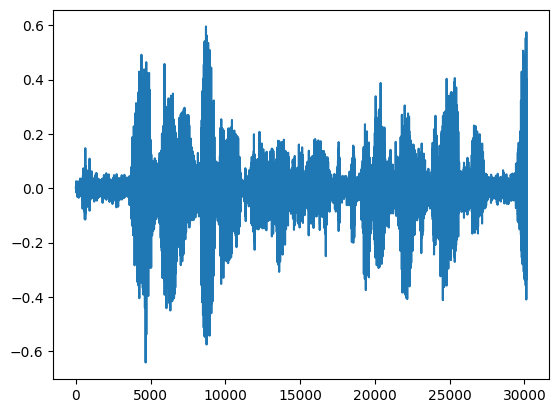

In [8]:
from IPython.display import Audio, display
model_forward_output = model(test_input, test_enroll_input, test_predict_delay)
print(model_forward_output.shape)
plt.plot(model_forward_output[0, 0, :].detach().cpu().numpy())
plt.show()
display(Audio(model_forward_output[0, 0, :].detach().cpu().numpy(), rate=8000))

In [11]:
from asteroid.utils.torch_utils import pad_x_to_y, jitable_shape
from asteroid.models.base_models import _shape_reconstructed, _unsqueeze_to_3d
from asteroid.models.base_models import BaseEncoderMaskerDecoder

In [12]:
shape = jitable_shape(test_input)
wav = _unsqueeze_to_3d(test_input)
model = model.cpu()
tf_rep = model.forward_encoder(wav)
enroll_emb = model.auxiliary(test_enroll_input)
predict_emb = model.predict2vec(test_predict_delay)
combine_emb = model.merge_embed(enroll_emb, predict_emb)
est_masks = model.forward_masker(tf_rep, combine_emb)
# est_masks_idx = model.forward_masker(tf_rep[:, :, :5], combine_emb[:, :5, :])
masked_tf_rep = model.apply_masks(tf_rep, est_masks)
decoded = model.forward_decoder(masked_tf_rep)
reconstructed = pad_x_to_y(decoded, wav)
print("tf rep shape: ", tf_rep.shape)
print("enroll_emb shape: ", enroll_emb.shape)
print("predict_emb shape: ", predict_emb.shape)
# emb_idx = 2
# print("predict emb: ", predict_emb[0, 0, :20, -1])
# print("predict_emb 2 shape: ", predict_emb2.shape, predict_emb2[0, 0, :20, -1])
# print("predict emb: ", predict_emb[0, 0, :20, -1])
print("combine_emb shape: ", combine_emb.shape)
# print("combine emb: ", combine_emb[0, emb_idx, 0:20])
print("est_masks shape: ", est_masks.shape) #, est_masks[0, 0, 0:20, 4])
# print("est masks2 shape: ", est_masks_idx.shape, est_masks_idx[0, 0, 0:20, -1])
print("masked_tf_rep shape: ", masked_tf_rep.shape)
print("decoded shape: ", decoded.shape)
print("reconstructed shape: ", reconstructed.shape)
print("reconstructed: ", reconstructed[0, 0, :64])
# print("forward output: ", model_forward_output[0, 0, :20])

tf rep shape:  torch.Size([1, 512, 624])
enroll_emb shape:  torch.Size([1, 256])
predict_emb shape:  torch.Size([1, 1, 256, 624])
combine_emb shape:  torch.Size([1, 624, 256])
est_masks shape:  torch.Size([1, 1, 512, 624])
masked_tf_rep shape:  torch.Size([1, 1, 512, 624])
decoded shape:  torch.Size([1, 1, 5000])
reconstructed shape:  torch.Size([1, 1, 5000])
reconstructed:  tensor([-0.0774,  0.0158, -0.0179,  0.0021,  0.2408,  0.0531, -0.0032,  0.0342,
         0.1886, -0.0391, -0.0104,  0.2170, -0.1652, -0.0723,  0.2133, -0.2061,
        -0.1004,  0.2212, -0.2069, -0.1825,  0.0936,  0.0466, -0.1560, -0.0257,
        -0.0631, -0.0100, -0.1175,  0.1505,  0.2693,  0.1645, -0.1527,  0.0178,
         0.1281, -0.1881,  0.1528,  0.1228, -0.1673, -0.0966,  0.1083,  0.2537,
        -0.2324, -0.2745, -0.1119, -0.3165, -0.1080,  0.3174, -0.0253,  0.1050,
         0.2204, -0.3044, -0.1599,  0.0142, -0.3112,  0.0061,  0.2494,  0.0261,
         0.0654, -0.0831, -0.2553,  0.0934,  0.0783, -0.1442, 

In [13]:
streaming_reconstructed = torch.zeros((wav.shape[0], wav.shape[-1]), device=wav.device)
# mixture_emb_buffer = torch.zeros((wav.shape[0], 1531, 512), device=wav.device)
# enroll_emb_buffer = torch.zeros((wav.shape[0], 1531, 256), device=wav.device)
# predict_emb_buffer = torch.zeros((wav.shape[0], 1531, 512), device=wav.device)
# initialize with enroll embedding
enroll_tf_emb = model.forward_encoder(test_enroll_input)
# predict_emb_buffer = enroll_tf_emb[:, :, -1531:].permute(0, 2, 1)
# mixture_emb_buffer = tf_rep[:, :, -1531:].permute(0, 2, 1)
# enroll_emb_buffer = enroll_emb.unsqueeze(1).repeat(1, 1531, 1)
curr_idx = 0
frame_predict_delay = torch.zeros((1, wav.shape[-1]), device=wav.device)
from tqdm import tqdm
for curr_idx in tqdm(range(600)):
    # print("curr idx: ", curr_idx, end=' ')
    curr_tf_rep = tf_rep[:, :, :curr_idx+1]

    predict_emb_frame = model.predict2vec(frame_predict_delay[..., :curr_idx*8+16])
    
    combine_emb_frame = model.merge_embed(enroll_emb, predict_emb_frame[..., :])
    
    # enroll_emb_buffer = torch.roll(enroll_emb_buffer, shifts=-1, dims=1)
    # enroll_emb_buffer[:, -1, :] = combine_emb_frame
    curr_est_masks = model.forward_masker(curr_tf_rep, combine_emb_frame)
    # print("curr est masks shape: ", curr_est_masks[:, :, :20, -1])
    curr_masked_tf_rep = model.apply_masks(curr_tf_rep[..., -1], curr_est_masks[..., -1]).squeeze(1)
    curr_decoded = model.forward_decoder(curr_masked_tf_rep.unsqueeze(-1))
    frame_predict_delay[0, curr_idx*8+16:curr_idx*8+32] += curr_decoded[0, 0, :]
    # print("frame tf: ", curr_idx, curr_tf_rep[:, :20, -1])
    # print("mask tf: ", curr_idx, curr_est_masks[0, 0, :20, -1])

100%|██████████| 600/600 [02:35<00:00,  3.87it/s]


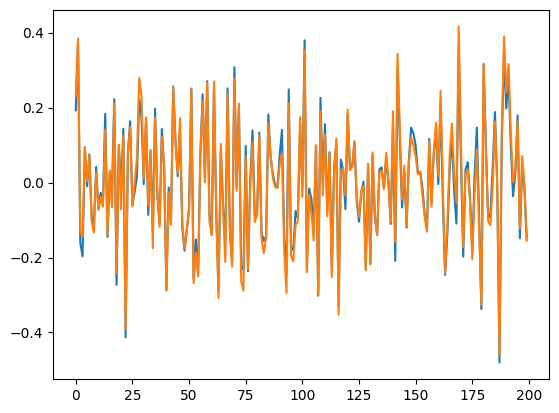

In [14]:
import matplotlib.pyplot as plt
plt.plot(frame_predict_delay[0, 16+1300:16+1500].detach().cpu().numpy())
plt.plot(reconstructed[0, 0, 1300:1500].detach().cpu().numpy())
plt.show()

In [42]:
print(test_predict_delay.shape, frame_predict_delay.shape)
print(test_predict_delay[0, :24])
print(frame_predict_delay[0, :24])
predict_emb_frame = model.predict2vec(frame_predict_delay[..., :24])
print(predict_emb_frame[0, 0, :20, 1])

torch.Size([1, 32000]) torch.Size([1, 32000])
tensor([ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         1.5061, -0.5435,  0.9687, -0.4585, -0.2378,  1.4177, -0.0588,  0.0114])
tensor([ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         1.2952, -1.2445,  1.1030, -0.5974, -0.6162,  2.1685, -0.4925, -0.3682],
       grad_fn=<SliceBackward0>)
tensor([-11.1129,   7.5805, -37.6755,  -4.1500, -10.1708,  10.7151,  -3.5644,
         -9.5574,   4.6117,  -3.9245,  16.6527,   0.4197, -15.8181,   5.9558,
         -7.7112,   3.2916,   0.7973,  -8.8043,  19.4619,  -0.8652],
       grad_fn=<SelectBackward0>)


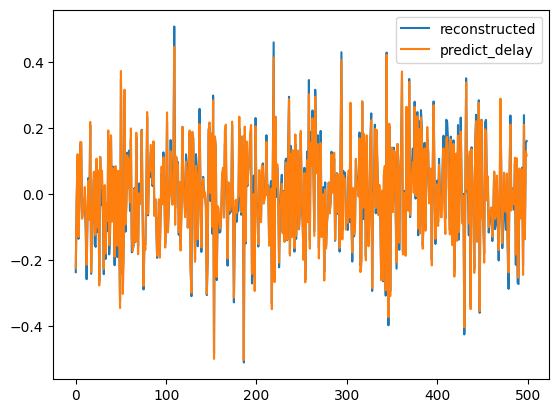

In [17]:

import matplotlib.pyplot as plt 
import numpy as np
plt_len = 500
start_pos = 3500
plt.plot(reconstructed[0, 0, start_pos:start_pos+plt_len].detach().cpu().numpy())
plt.plot(frame_predict_delay[0, start_pos+16:plt_len+16+start_pos].detach().cpu().numpy())
# plt.plot(enroll[start_pos:start_pos+plt_len, ])
plt.legend(["reconstructed", "predict_delay"])
plt.show()

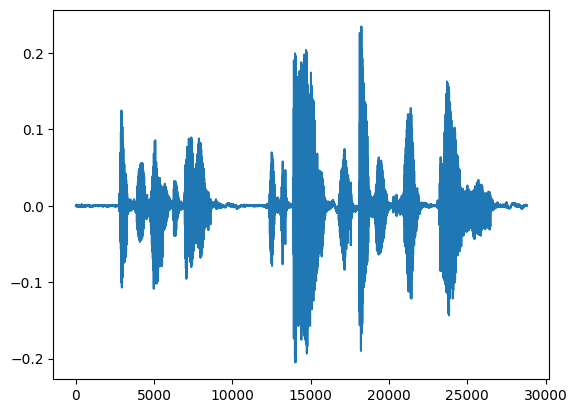

In [34]:
plt.plot(enroll)

In [35]:
print(enroll.shape)

(28800,)


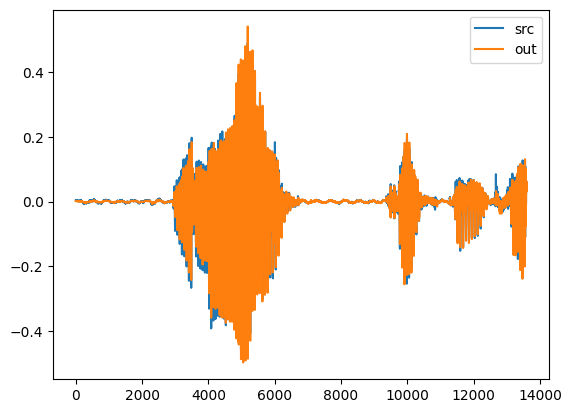

In [61]:
test_outputpath = "/data1/wangyiwen/repos/graduateproject/speakerbeam/egs/libri2mix_sep2vec/exp/auto_regression_0_3_16sample_cgLN/out_mix_src_enroll/1188-133604-0025_4992-23283-0016_SRC_0.wav"
test_outputpath2 = "/data1/wangyiwen/repos/graduateproject/speakerbeam/egs/libri2mix_sep2vec/exp/auto_regression_0_3_16sample_cgLN/out_mix_src_enroll/1188-133604-0025_4992-23283-0016_s0.wav"
wav_out1, _ = sf.read(test_outputpath, dtype="float32")
wav_out2, _ = sf.read(test_outputpath2, dtype="float32")
plt.plot(wav_out1[1500:15100])
plt.plot(wav_out2[1500:15100])
plt.legend(["src", "out"])
plt.show()

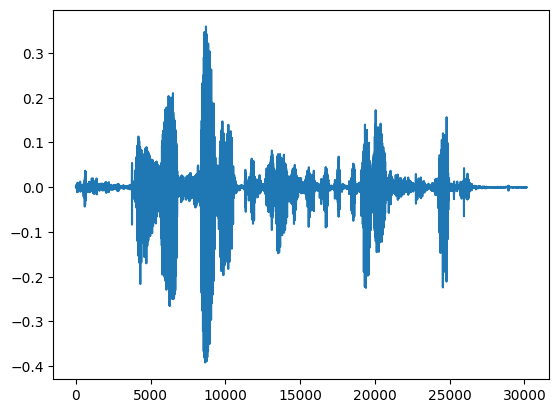

In [52]:
test_output2 = "/data1/wangyiwen/repos/graduateproject/speakerbeam/egs/libri2mix/exp/casual_enroll_only_chunkwise_cgLN/out/4077-13754-0001_5142-33396-0065_s0.wav"
wav_out2, _ = sf.read(test_output2, dtype="float32")
plt.plot(wav_out2[0:])

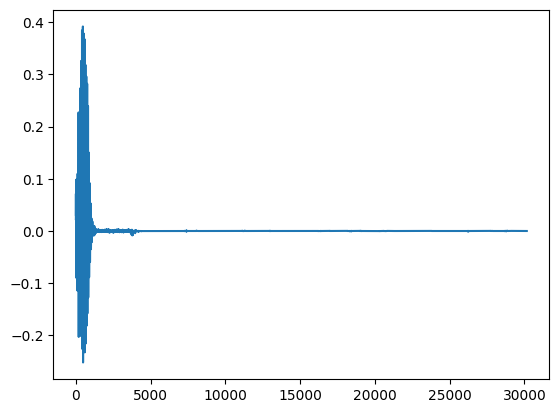

In [1]:
import matplotlib.pyplot as plt 
import soundfile as sf 
wavpath = "/data1/wangyiwen/repos/graduateproject/speakerbeam/egs/libri2mix_sep2vec/exp/auto_regression_0_3_16sample_cgLN/out_autoregression/4077-13754-0001_5142-33396-0065_s0.wav"
wav_td, _ = sf.read(wavpath)
plt.plot(wav_td[:])
plt.show()

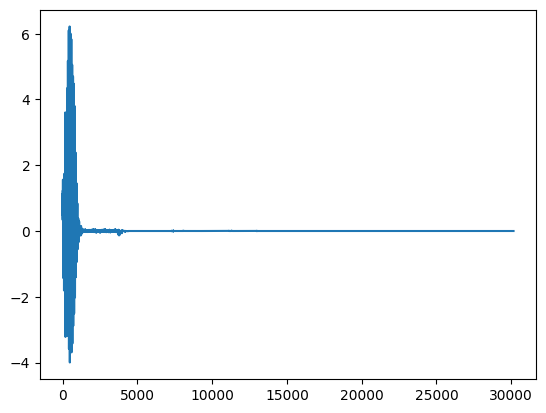

In [3]:
import numpy as np 
npy_info = np.load("/data1/wangyiwen/repos/graduateproject/speakerbeam/egs/libri2mix_sep2vec/exp/auto_regression_0_3_16sample_cgLN/out/4077-13754-0001_5142-33396-0065_s0.npy")
plt.plot(npy_info.T)

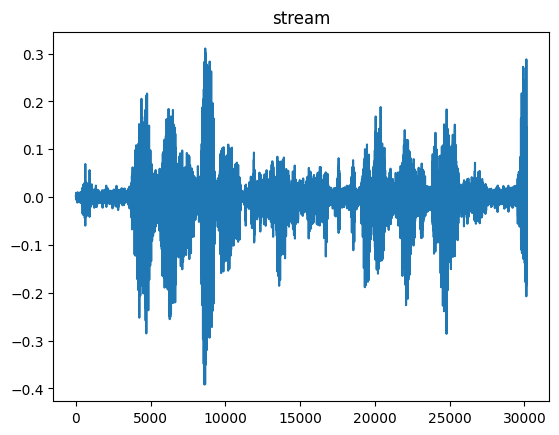

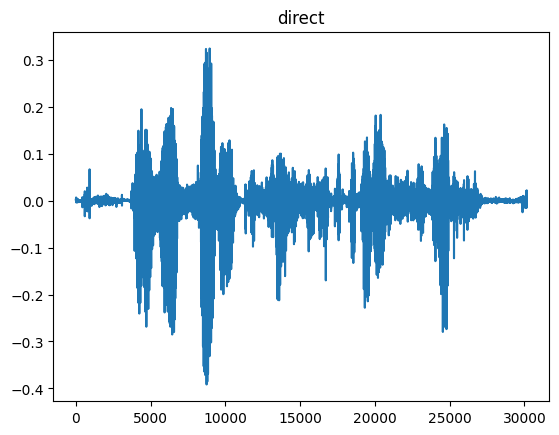

In [45]:
forward_outputpath = "/data1/wangyiwen/repos/graduateproject/speakerbeam/egs/libri2mix_sep2vec/exp/auto_regression_0start_500epoch_16sample_cgLN/out_forward/4077-13754-0001_5142-33396-0065_s0.wav"
stream_outputpath = "/data1/wangyiwen/repos/graduateproject/speakerbeam/egs/libri2mix_sep2vec/exp/auto_regression_0start_500epoch_16sample_cgLN/out_stream/4077-13754-0001_5142-33396-0065_s0.wav"
import soundfile as sf
import numpy as np
from IPython.display import Audio, display
wav_forward, _ = sf.read(forward_outputpath, dtype="float32")
wav_stream, _ = sf.read(stream_outputpath, dtype="float32")
plt_start = 0
plt_len = wav_forward.shape[0] - plt_start
plt.plot(wav_stream[plt_start:plt_start+plt_len])
display(Audio(wav_stream, rate=8000))
plt.title("stream")
plt.show()
plt.plot(wav_forward[plt_start:plt_start+plt_len])
plt.title("direct")
display(Audio(wav_forward, rate=8000))
# plt.legend(["stream", "forward"])
plt.show()